Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `~/Documents/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

# Create a KP model

In [3]:
using Symbolics, LinearAlgebra
using PyCall, PyPlot

In [4]:
#read Hamiltonian created in createHam.ipynb 
dirHam="/home/martinez/Documents/repos/kp-lflm-group/Models_Hamiltonian/";name="kane"

Htot=KPpack.readHamiltonian(dirHam,name)

strK=["k_x","k_y","k_z"];
Emomentum=KPpack.setMomentum(strK);
HVar=KPpack.getVar(Htot);

In [5]:
real(Htot)

8×8 Matrix{Num}:
  E_g + VBO + c*(1 + 2F)*(k_x^2 + k_y^2 + k_z^2)  …                      0
 0                                                                       0.333333Δ
 0                                                                       0
 0                                                                       0
 0                                                                       0
 0                                                …  -c*k_x*k_z*(6g_3 + (-E_p) / E_g)
 0                                                   -c*k_y*k_z*(6g_3 + (-E_p) / E_g)
 0                                                                 VBO + 0.333333Δ - c*(k_x^2 + k_y^2 + k_z^2) - c*(g_1 + 4g_2 + (-E_p) / E_g)*(k_z^2) - c*(g_1 - 2g_2)*(k_x^2 + k_y^2)

In [6]:
var=Emomentum[3] 
H0,H1,H2=KPpack.createKm(Htot,var);
p=HVar[13];
H1l,H1r=KPpack.createH1Corr(H1,p, Emomentum);

In [7]:
real(H2)

8×8 Matrix{Num}:
 c*(1 + 2F)*(k_x^2 + k_y^2) - c*(1 + 2F)*(1 + k_x^2 + k_y^2)  …    0
        0                                                          0
        0                                                          0
        0                                                          0
        0                                                          0
        0                                                     …    0
        0                                                          0
        0                                                        -((E_p*c - E_g*c - E_g*c*g_1 - 4E_g*c*g_2) / E_g)

## test the bulk calculation

In [8]:
material="GaAs"; Temp=0; soc=true; opt="calc"
tipo="KaneII";
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp,opt);
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [9]:
kmax= 1.4; Nt=100; consth=0.038; const2=sqrt(consth)
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,Htot,Emomentum,consth,const2)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

In [10]:
mm.F

-1.0042303659815195

# Plot band diagram

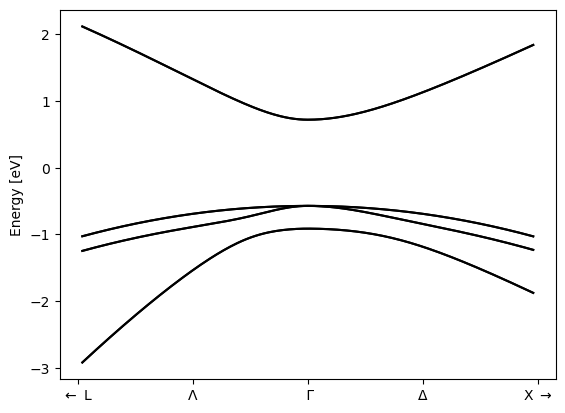

In [11]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

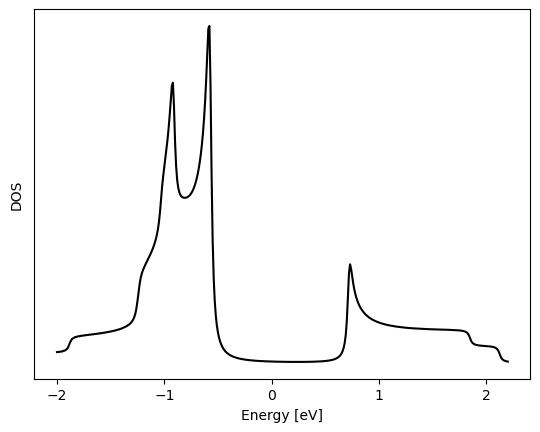

In [12]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [13]:
structure=["AlGaAs_0.3" "15";
    "AlGaAs_0.3" "10";
    "GaAs" "5";
    "AlGaAs_0.3" "10";
    "AlGaAs_0.3" "15";]

#structure=["AlGaAs_0.2" "10";
#    "GaAs" "3";
#    "AlGaAs_0.2" "10";]

Npts,layer,nlayer=KPpack.setStructure(structure,0.25,Temp)

X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp,opt);
Npts

48

# Plot structure

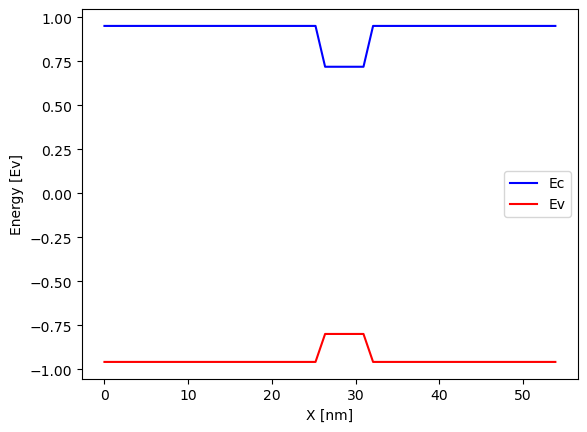

In [14]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

  6.139685 seconds (8.77 M allocations: 534.979 MiB, 7.94% gc time, 95.98% compilation time)


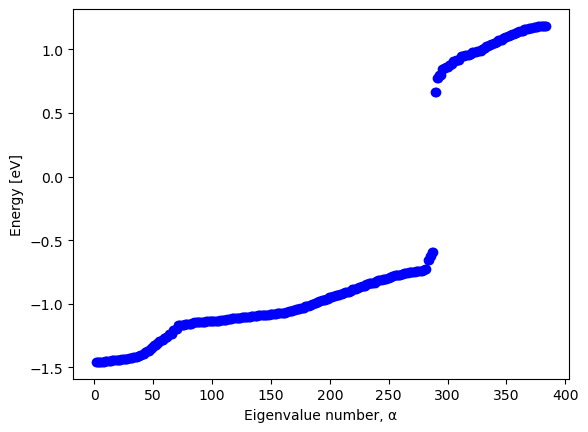

In [15]:
c=0.038; cps=sqrt(c); dx=X[2]-X[1];  cr=0.9; s=0.6; pb=true

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,H0,H1l,H1r,H2,c,cps,dx,Emomentum,pb,cr,s);
KPpack.PloteigvQW(Npts,Eqw0);


# QW Band Structure Calculation

In [16]:
kmax= 1.2; Nt=100;
nc=4; nv=6

sV,sC,pos=KPpack.eigenValQW(real(Eqw0))

pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,sV,sC,Emomentum,pb,cr,s);

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax+0.1,Nt,dx,pl,pm,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,sV,sC,Emomentum,pb,cr,s);

 14.232674 seconds (13.32 M allocations: 1.847 GiB, 3.33% gc time, 35.76% compilation time)
  8.236139 seconds (6.04 M allocations: 1.318 GiB, 2.32% gc time)


## Valence Band 

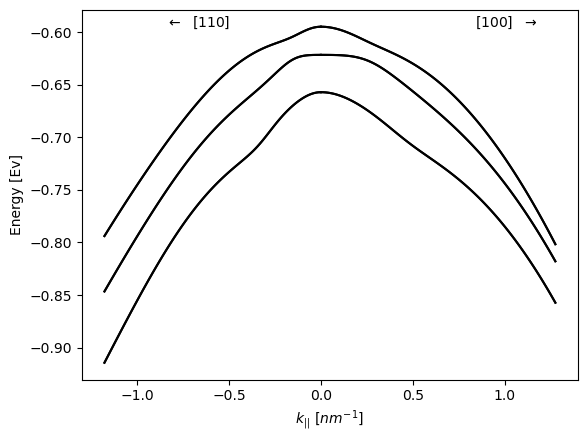

In [17]:
option="complete_V"; poslab=sV
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

## Conduction Band

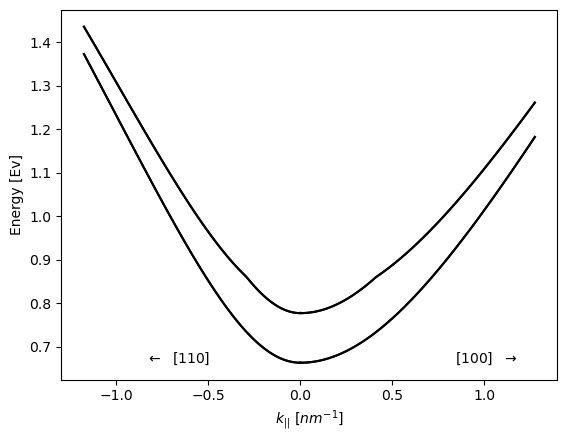

In [18]:
option="complete_C"; poslab=sC
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

# DOS QW

## DOS Valence Band

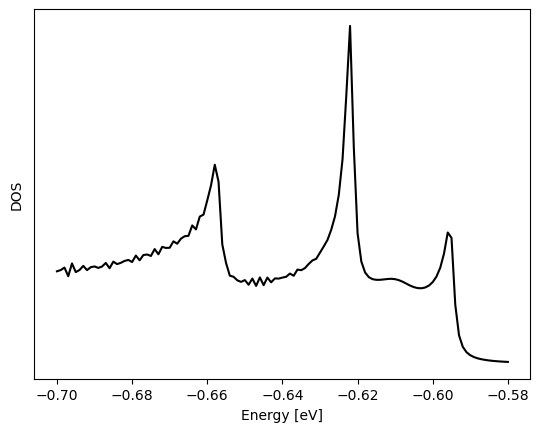

In [38]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.7,-0.58,0.001,Evqw,2e-3);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

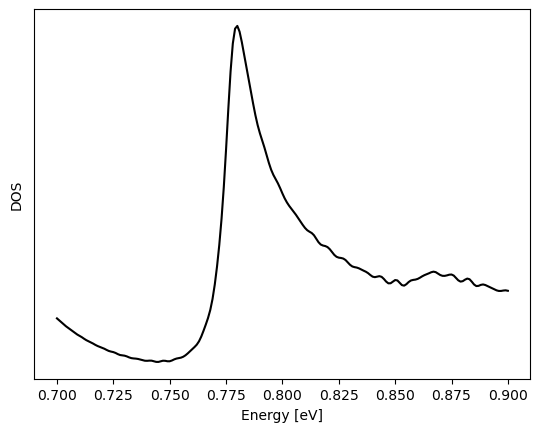

In [20]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.7,0.9,0.001,Evqw,1e-2);
KPpack.PlotDOS(EDOSc,aDOSc);

In [21]:
kx,ky=0.2,0.2
hns=KPpack.FDHamiltonian(H0,H1l,H1r,H2,mlayer,kx,ky,dx,c,cps,Npts,Emomentum,pb,cr,s)

384×384 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 3264 stored entries:
⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓
⠀⠻⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠹⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⣷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣆⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣦⠀
⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⣷

## =====================================================|

In [22]:
boundPoints

4-element Vector{Float64}:
 15.0
 23.0
 28.0
 36.0

In [23]:
i=12
kx,ky=0.0,0.0

H0Re,H0Im=KPpack.createFuncFD(H0,Emomentum); H1rRe,H1rIm=KPpack.createFuncFD(H1r,Emomentum); H1lRe,H1lIm=KPpack.createFuncFD(H1l,Emomentum)
H2Re,H2Im=KPpack.createFuncFD(H2,Emomentum);
    
H2n=KPpack.evalFuncFD(H2Re,H2Im,mlayer,i,kx,ky,c,cps,cr,s)

mA=KPpack.createFDAmatrix(mlayer,i,H0Re,H0Im,H2Re,H2Im,kx,ky,dx,c,cps,cr,s); 
mB=KPpack.createFDBmatrix(mlayer,i+1,H1rRe,H1rIm,H1lRe,H1lIm,H2Re,H2Im,kx,ky,dx,c,cps,cr,s);
mC=KPpack.createFDCmatrix(mlayer,i-1,H1rRe,H1rIm,H1lRe,H1lIm,H2Re,H2Im,kx,ky,dx,c,cps,cr,s);
mlayer[i].material

"AlGaAs_0.3"

In [24]:
real(H2n)

8×8 Matrix{Float64}:
 0.0345359  0.0       0.0       0.0       …  0.0       0.0       0.0
 0.0        0.138244  0.0       0.0          0.0       0.0       0.0
 0.0        0.0       0.138244  0.0          0.0       0.0       0.0
 0.0        0.0       0.0       0.100957     0.0       0.0       0.0
 0.0        0.0       0.0       0.0          0.0       0.0       0.0
 0.0        0.0       0.0       0.0       …  0.138244  0.0       0.0
 0.0        0.0       0.0       0.0          0.0       0.138244  0.0
 0.0        0.0       0.0       0.0          0.0       0.0       0.100957

In [25]:
EigH2=eigvals(H2n)

8-element Vector{Float64}:
 0.034535875806487336
 0.034535875806487336
 0.10095695347984954
 0.10095695347984954
 0.138244
 0.138244
 0.138244
 0.138244

In [26]:
eigneg=0; eigpos=0

for i in 1:length(EigH2)
    if EigH2[i] <= 0
        eigneg += EigH2[i]
    else
        eigpos += EigH2[i]
    end
end

abs(eigneg/eigpos)

0.0

save a file with band structure

In [27]:
# save a file in folder data with a name given by the user
dat=hcat(Ktot,Etot);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)

# Symbolic

## create a Finite differences matrices

# =======================================================

In [28]:
i=20; s=0.6
kx,ky=0.0,0.0
cps=0.38
H1Re,H1Im=KPpack.createFuncFD(H1,Emomentum);

H1n=KPpack.evalFuncFD(H1Re,H1Im,mlayer,i,kx,ky,c,cps,cr,s)
H1n

8×8 Matrix{ComplexF64}:
      0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im      0.0+0.0im
      0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im
      0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im
 -1.75048+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im
      0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  1.75048+0.0im
      0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im      0.0+0.0im
      0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im
      0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im

In [29]:
H1rRe,H1rIm=KPpack.createFuncFD(H1r,Emomentum); H1lRe,H1lIm=KPpack.createFuncFD(H1l,Emomentum);

H1rn=KPpack.evalFuncFD(H1rRe,H1rIm,mlayer,i,kx,ky,c,cps,cr,s); H1ln=KPpack.evalFuncFD(H1lRe,H1lIm,mlayer,i,kx,ky,c,cps,cr,s)
H1ln

8×8 Matrix{ComplexF64}:
       0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im      0.0+0.0im
       0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im
       0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im
 -0.700194+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im
       0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  1.05029+0.0im
       0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im      0.0+0.0im
       0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im
       0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im      0.0+0.0im

# ================================

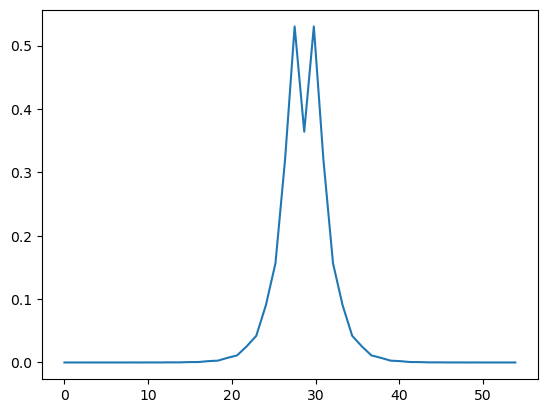

0.7772286134589718

In [30]:
i=pos+4


Evec=EVqw0[1:8:end,i]

#vv=Evec.*transpose(Evec')
vv=abs.(Evec)
#vv=Evec
#lt.xlim(150,250)
plt.plot(X,real(vv))
Eqw0[i]

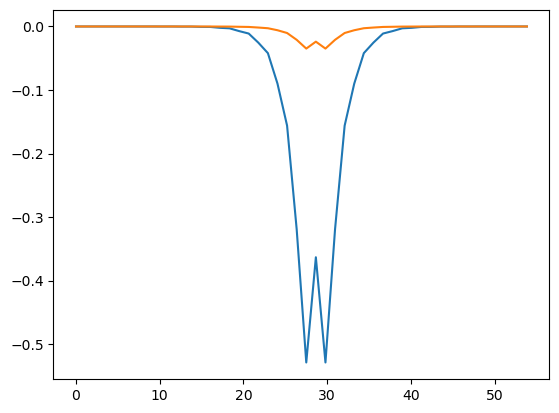

In [31]:
plt.plot(X,real(Evec))
plt.plot(X,imag(Evec));

In [32]:
boundPoints

4-element Vector{Float64}:
 15.0
 23.0
 28.0
 36.0

In [33]:
 i=24

((1-sqrt(3))/2)*mlayer[i].g1 < mlayer[i].g2 && mlayer[i].g2<((1+sqrt(3))/2)*mlayer[i].g1

true

In [34]:
((4*(2*mlayer[i].g2^2-2*mlayer[i].g1*mlayer[i].g2-mlayer[i].g1^2)*cps)/(mlayer[i].delta*(2*mlayer[i].g2+mlayer[i].g1)))

-27.70495257721064

In [35]:
w=0.8
Lm=(mlayer[i].g1+4*mlayer[i].g2-(w*mlayer[i].Ep/mlayer[i].Eg)); L=mlayer[i].g1+4*mlayer[i].g2
M=mlayer[i].g1-2*mlayer[i].g2
Nm=(6*mlayer[i].g3-(w*mlayer[i].Ep/mlayer[i].Eg)); N=6*mlayer[i].g3

17.580000000000002

In [36]:
-Nm

-4.0974456879525984